# Experiment on finance data

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
CAD, EUR, JPY, GBP, CHF, AUD, HKD, NZD, KRW, MXN

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
def plot_experiment(model, ylims=None, names=[], title='Finance experiment'):
    """
    Plot currency exchange mogptk experiment
    """
    x_train = model.data.X
    y_train = model.data.Y
    x_all = model.data.X_all
    y_all = model.data.Y_all
    x_pred = {i:array for i, array in enumerate(data.X_all)}
    
    try:
        x_pred, mean_pred, var_pred = model.predict(x_pred)
    except:
        pass
    
    f, axarr = plt.subplots(5, 2, sharex=True, figsize=(20, 15))
    axarr = axarr.reshape(-1)
    
    for i in range(len(x_train)):
        axarr[i].plot(x_train[i], y_train[i], '.k', label='Train', )
        axarr[i].plot(x_all[i], y_all[i], '--', label='Test', c='gray')
        try:
            axarr[i].plot(x_pred[i], mean_pred[i], label='Pred', c=sns.color_palette()[i])
            axarr[i].fill_between(x_pred[i].reshape(-1),
                                  mean_pred[i] + 2 * np.sqrt(var_pred[i]),
                                  mean_pred[i] - 2 * np.sqrt(var_pred[i]),
                                  label='95% c.i',
                                  color=sns.color_palette()[i],
                                  alpha=0.4)
        except:
            pass
        axarr[i].legend(ncol=4)
        axarr[i].set_title(names[i])
        axarr[i].set_xlim(x_train[i][0], x_train[i][-1])
    plt.suptitle(title, y=1.02)
    plt.tight_layout()

## Load dataset

In [4]:
df = pd.read_csv('data/currency_exchange/data.csv')
df.head()

,Jul.Day,YYYY/MM/DD,Wdy,CAD/USD,EUR/USD,JPY/USD,GBP/USD,CHF/USD,AUD/USD,HKD/USD,NZD/USD,KRW/USD,MXN/USD
0,2457757,2017/01/03,Tue,1.3438,0.96013,117.67,0.81596,1.02659,1.3831,7.7563,1.4436,1208.5,20.909
1,2457758,2017/01/04,Wed,1.3293,0.95461,117.43,0.81328,1.02277,1.3755,7.7553,1.4394,1198.6,21.385
2,2457759,2017/01/05,Thu,1.3216,0.94353,115.42,0.80566,1.01078,1.3637,7.7545,1.4244,1183.2,21.399
3,2457760,2017/01/06,Fri,1.3216,0.94704,116.85,0.81214,1.01513,1.3692,7.7552,1.4343,1200.4,21.302
4,2457763,2017/01/09,Mon,1.3222,0.94558,116.08,0.82201,1.01489,1.3582,7.7559,1.4233,1202.0,21.336


extract data to use

In [5]:
# obtain absolute day starting with monday = 1
df['Day'] = df['Jul.Day'] - df['Jul.Day'].min() + 2

df2 = df[['Day',
          'CAD/USD',
          'EUR/USD',
          'JPY/USD',
          'GBP/USD',
          'CHF/USD',
          'AUD/USD',
          'HKD/USD',
          'NZD/USD',
          'KRW/USD',
          'MXN/USD']]
df2.head()

,Day,CAD/USD,EUR/USD,JPY/USD,GBP/USD,CHF/USD,AUD/USD,HKD/USD,NZD/USD,KRW/USD,MXN/USD
0,2,1.3438,0.96013,117.67,0.81596,1.02659,1.3831,7.7563,1.4436,1208.5,20.909
1,3,1.3293,0.95461,117.43,0.81328,1.02277,1.3755,7.7553,1.4394,1198.6,21.385
2,4,1.3216,0.94353,115.42,0.80566,1.01078,1.3637,7.7545,1.4244,1183.2,21.399
3,5,1.3216,0.94704,116.85,0.81214,1.01513,1.3692,7.7552,1.4343,1200.4,21.302
4,8,1.3222,0.94558,116.08,0.82201,1.01489,1.3582,7.7559,1.4233,1202.0,21.336


## Create and fit model

In [6]:
# Add data
data = mogptk.Data()

# columns to use
cols = list(df2)[1:]

for c in cols:
    x = (df2['Day'].values).astype(float).reshape(-1, 1)
    # y = df2[c].values # normal
    y = np.log(df2[c].values) # log
    data.add(x, y)

Remove data to simulate sensor failure

In [7]:
# randomly sample from the data
for i in range(len(cols)):
    data.remove_randomly(channel=i, pct=0.7)

# drop chunks to simulate sensor failure
data.remove_range(0, None, 30)
data.remove_range(1, 90, 120)
data.remove_range(2, 480, 520)
data.remove_range(3, 200, 250)
data.remove_range(4, None, 30)
data.remove_range(5, 700, None)
data.remove_range(6, 650, None)
data.remove_range(7, 500, 550)
data.remove_range(9, 700, None)

### Create model

In [8]:
model_mosm = mogptk.MOSM(data, Q=6)
model_mosm.init_params('means')

### Train

In [9]:
%%time
model_mosm.train(method='L-BFGS-B', maxiter=3000, learning_rate=0.001, disp=True, tol=1e-15)

Building...
Optimizing...
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -5219.506426
  Number of iterations: 5000
  Number of functions evaluations: 5306
Done
CPU times: user 1h 15min 29s, sys: 7min 41s, total: 1h 23min 10s
Wall time: 1h 9min 1s


In [10]:
x_pred = {i:array for i, array in enumerate(data.X_all)}

x_pred, y_pred, var_pred = model_mosm.predict(x_pred)

mosm_mae = np.zeros(len(cols))
mosm_mape = np.zeros(len(cols))
mosm_mse = np.zeros(len(cols))

# errors per channel
for i in range(len(cols)):
    idx = data.Y_all[i] != 0
    mosm_mae[i] = np.abs(data.Y_all[i] - y_pred[i]).mean() # MAE
    mosm_mape[i] = np.abs((data.Y_all[i][idx] - y_pred[i][idx]) / data.Y_all[i][idx] * 100).mean() # MAPE
    mosm_mse[i] = ((data.Y_all[i] - y_pred[i])**2).mean() # MSE

pd.DataFrame(np.c_[mosm_mae, mosm_mape, mosm_mse], columns=['MAE', 'MAPE%', 'MSE'])

,MAE,MAPE%,MSE
0,0.002630,1.009077,1.844620e-05
1,0.003018,2.741780,2.231038e-05
2,0.002848,0.060451,1.945280e-05
3,0.004282,1.634589,4.990491e-05
4,0.002316,49.164524,1.201005e-05
5,0.003702,1.301364,4.146787e-05
6,0.000599,0.029114,6.989507e-07
7,0.004096,1.173037,3.907444e-05
8,0.002957,0.042141,1.890259e-05
9,0.005551,0.187423,7.283577e-05


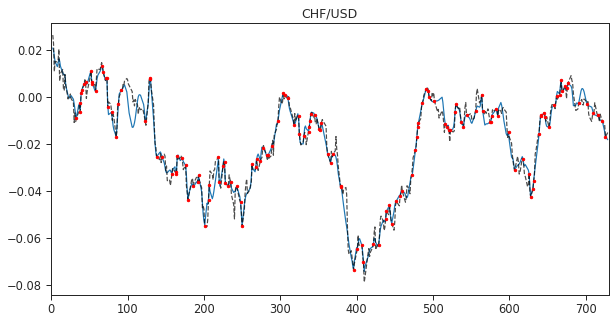

In [24]:
i = 4

plt.plot(data.X_all[i], data.Y_all[i], '--k', label='True', zorder=2, alpha=0.7)
plt.plot(data.X[i], data.Y[i], '.r', zorder=2)
plt.plot(x_pred[i], y_pred[i], label='Predicted', zorder=1)
plt.title(cols[i])
plt.xlim(-1, 730);

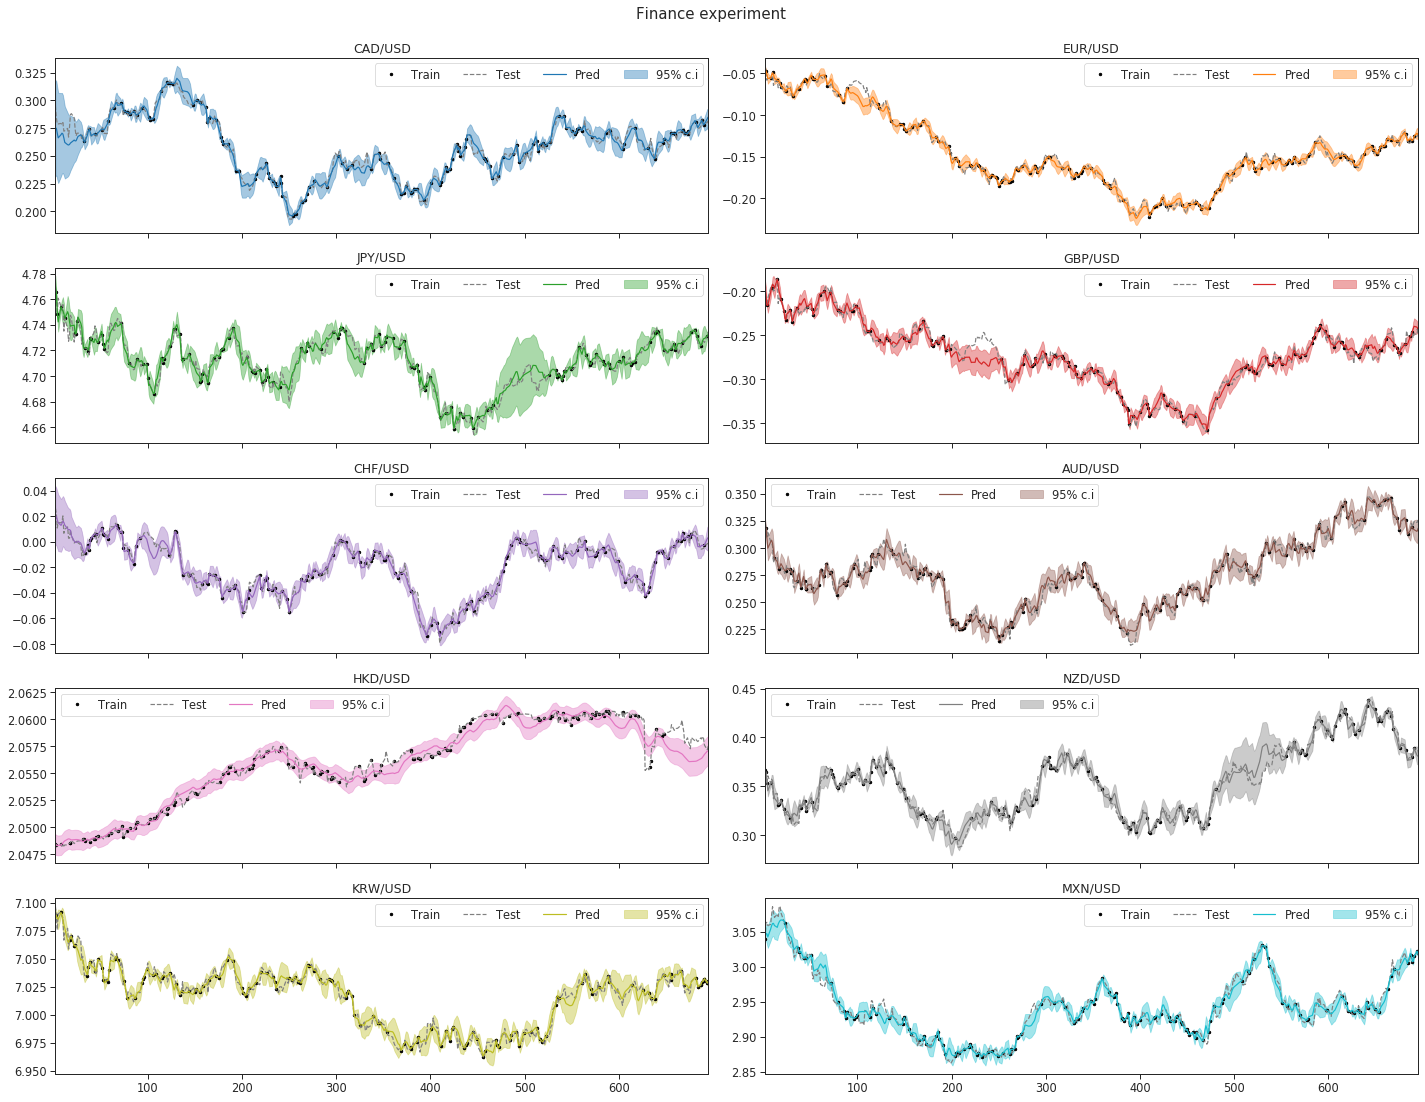

In [12]:
plot_experiment(model_mosm, names=cols)
plt.savefig('output/finance_mosm_lognorm.pdf', bbox_inches='tight')